In [1]:
import numpy as np
import pandas as pd
import cudf

In [6]:
from typing import Union

import numpy as np
from sklearn.metrics import average_precision_score, mean_squared_error

def rmse(y_true: Union[np.ndarray, list], y_pred: Union[np.ndarray, list]) -> float:
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmsle(y_true: Union[np.ndarray, list], y_pred: Union[np.ndarray, list]) -> float:
    return rmse(np.log1p(y_true), np.log1p(y_pred))

In [7]:
y = pd.read_feather("../input/train.ftr")["Global_Sales"]

In [2]:
preds = [
    "036_use_top_10_seed_average/seed_054",
    "034_seed_average_033/seed_028",
    "029_seed_average_028",
    "032_groupby_concat_category",
    "033_add_log_user_count",
    "034_seed_average_033",
    "035_use_top_k",
    "036_use_top_10_seed_average",
    "037_use_top_10_seed_average_lgb",
    "039_top_10_pct_catboost",
    "040_add_target_encoding",
]

In [4]:
oof_preds = []
test_preds = []
for pred in preds:
    oof_preds.append(np.load("../output/" + pred + "/oof_preds.npy"))
    test_preds.append(np.load("../output/" + pred + "/test_preds.npy"))

In [5]:
oof_preds

[array([83.30832943, 94.20234028, 35.19430399, ...,  3.22761848,
        49.31173758, 25.47016217]),
 array([72.85822583, 66.28794095, 30.09998884, ...,  3.3797114 ,
        29.77360796, 17.9052972 ]),
 array([69.64361568, 48.65784512, 30.87715422, ...,  3.1749756 ,
        33.08355857, 16.61607236]),
 array([87.73656149, 70.64878519, 28.58280271, ...,  4.43685726,
        30.09384998, 19.21847527]),
 array([75.98714194, 69.83620602, 28.10197318, ...,  3.91097095,
        26.6372438 , 14.61794349]),
 array([75.12870223, 70.55133108, 31.66654234, ...,  3.49608182,
        31.01063194, 18.15212116]),
 array([80.63455775, 80.82278889, 39.75217772, ...,  3.846907  ,
        59.73462581, 26.13773016]),
 array([76.96882666, 88.31871114, 38.37555905, ...,  3.51716766,
        62.04136763, 28.05525878]),
 array([75.26190313, 80.94229107, 42.84801839, ...,  3.57385527,
        69.83639512, 29.98570445]),
 array([54.13784431, 73.48650995, 37.99800678, ...,  3.09834642,
        34.2165687 , 23.56

In [9]:
rmsle(y, np.mean(oof_preds, axis=0))

0.9981296734217027

In [8]:
sample_submission = pd.read_csv("../input/sample_submission.csv")

In [10]:
def loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, oof_pred in zip(weights, oof_preds):
            final_prediction += weight*oof_pred

    return rmsle(y, final_prediction)

In [11]:
starting_values = [0.5]*len(oof_preds)

In [12]:
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})

In [13]:
from scipy.optimize import minimize

In [14]:
bounds = [(0,1)]*len(oof_preds)

In [15]:
res = minimize(loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

In [16]:
res["fun"]

0.9910061058704241

<AxesSubplot:>

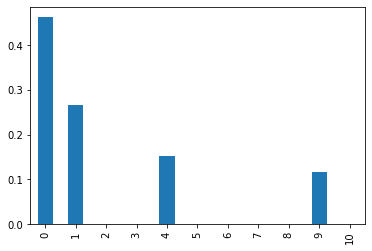

In [17]:
pd.Series(res["x"]).plot.bar()

In [18]:
final_prediction = 0
for weight, test_pred in zip(res["x"], test_preds):
        final_prediction += weight*test_pred

In [19]:
sample_submission["Global_Sales"]=final_prediction

In [20]:
sample_submission.to_csv("../output/slsqp_weight_average_submission_1.csv", index=False)